# Calibration tests

## Load data

In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
sns.set()
pd.set_option('display.max_columns', None)

titles = False

In [2]:
data = pkl.load(open('data/data.pkl','rb'))
data.head()

,user_id,exp_id,sch_id_1,sch_id_2,pair,realconf,rec_time,time,userconf,user_sub_val,user_ans_is_match,mouse_loc,order,token_path,term_match,word_net
0,171,14,134,180,"(134, 180)",0,2020-12-19 12:28:39,26,34,67,1,"(1608373691424,1094.4655929721816,406.656,true...",1,0.484821,0.619156,1.0
1,171,14,134,182,"(134, 182)",0,2020-12-19 12:28:45,6,38,69,1,"(1608373716894,897.6866764275256,593.28,true,f...",2,0.454945,0.578095,1.0
2,171,14,153,183,"(153, 183)",1,2020-12-19 12:28:54,9,24,38,0,"(1608373722986,1006.3836017569546,669.312,true...",3,0.552425,0.397624,1.0
3,171,14,149,180,"(149, 180)",0,2020-12-19 12:28:57,3,14,57,1,"(1608373731943,1093.528550512445,667.008,true,...",4,0.502679,0.619156,1.0
4,171,14,163,176,"(163, 176)",1,2020-12-19 12:29:01,4,24,62,1,"(1608373734940,1104.7730600292825,660.096,true...",5,0.570769,0.650000,1.0


### Normalize confidence and filter outliers

In [3]:
data['userconf'] /= 100

In [4]:
time_describe = data[['time']].describe()
lower_bound = max(0, time_describe.loc['mean'].item() - 2 * time_describe.loc['std'].item())
upper_bound = time_describe.loc['mean'].item() + 2 * time_describe.loc['std'].item()
problematic_users = data[(lower_bound > data['time']) | (data['time'] > upper_bound)]['user_id'].unique()
data = data[~data['user_id'].isin(problematic_users)].reset_index(drop=True)
data.head()

,user_id,exp_id,sch_id_1,sch_id_2,pair,realconf,rec_time,time,userconf,user_sub_val,user_ans_is_match,mouse_loc,order,token_path,term_match,word_net
0,174,14,134,180,"(134, 180)",0,2020-12-19 12:37:19,14,0.40,30,0,"(1608374227475,744.9493142516399,642.208883553...",1,0.484821,0.619156,1.0
1,174,14,134,182,"(134, 182)",0,2020-12-19 12:37:28,9,0.24,38,0,"(1608374241158,1025.0685748360168,622.32893157...",2,0.454945,0.578095,1.0
2,174,14,153,183,"(153, 183)",1,2020-12-19 12:37:38,10,0.20,40,0,"(1608374250764,799.1413237924866,670.732292917...",3,0.552425,0.397624,1.0
3,174,14,149,180,"(149, 180)",0,2020-12-19 12:37:46,8,0.14,43,0,"(1608374260455,799.1413237924866,649.123649459...",4,0.502679,0.619156,1.0
4,174,14,163,176,"(163, 176)",1,2020-12-19 12:37:51,5,0.10,55,1,"(1608374268412,883.8640429338104,583.433373349...",5,0.570769,0.650000,1.0


## Evaluation columns

In [5]:
data['confusion'] = pd.Series(dtype=float)
data.loc[(data['user_ans_is_match']==1)&(data['realconf']==1), 'confusion'] = 'TP'
data.loc[(data['user_ans_is_match']==1)&(data['realconf']==0), 'confusion'] = 'FP'
data.loc[(data['user_ans_is_match']==0)&(data['realconf']==0), 'confusion'] = 'TN'
data.loc[(data['user_ans_is_match']==0)&(data['realconf']==1), 'confusion'] = 'FN'

data['correct'] = (data['user_ans_is_match'] == data['realconf']).astype(int)

In [6]:
data.head()

,user_id,exp_id,sch_id_1,sch_id_2,pair,realconf,rec_time,time,userconf,user_sub_val,user_ans_is_match,mouse_loc,order,token_path,term_match,word_net,confusion,correct
0,174,14,134,180,"(134, 180)",0,2020-12-19 12:37:19,14,0.40,30,0,"(1608374227475,744.9493142516399,642.208883553...",1,0.484821,0.619156,1.0,TN,1
1,174,14,134,182,"(134, 182)",0,2020-12-19 12:37:28,9,0.24,38,0,"(1608374241158,1025.0685748360168,622.32893157...",2,0.454945,0.578095,1.0,TN,1
2,174,14,153,183,"(153, 183)",1,2020-12-19 12:37:38,10,0.20,40,0,"(1608374250764,799.1413237924866,670.732292917...",3,0.552425,0.397624,1.0,FN,0
3,174,14,149,180,"(149, 180)",0,2020-12-19 12:37:46,8,0.14,43,0,"(1608374260455,799.1413237924866,649.123649459...",4,0.502679,0.619156,1.0,TN,1
4,174,14,163,176,"(163, 176)",1,2020-12-19 12:37:51,5,0.10,55,1,"(1608374268412,883.8640429338104,583.433373349...",5,0.570769,0.650000,1.0,TP,1


## Calibration analysis

### Over-all-question calibration

#### Calibration as meanconf - precision

,userconf,time,precision,calibration (pre)
user_id,,,,
174,0.537,3.90,0.60,-0.063
178,0.574,16.45,0.65,-0.076


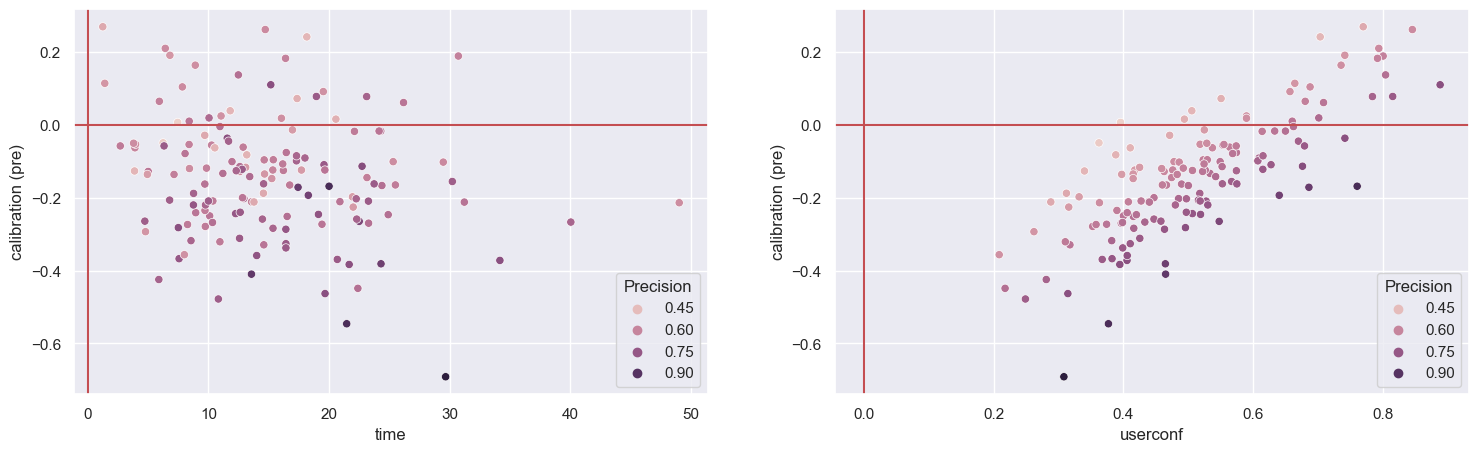

In [7]:
means = data.loc[data['confusion'].isin(['TP', 'FP']), ['user_id', 'userconf', 'time', 'correct']].groupby('user_id').mean()
means = means.rename(columns={'correct':'precision'})
means['calibration (pre)'] = means['userconf'] - means['precision']
display(means.head(2))

fig, axes = plt.subplots(1,2, figsize=(18,5))

graph = sns.scatterplot(means, x='time', y='calibration (pre)', hue='precision', ax=axes[0])
graph.set(title='Calibration (pre) by mean answering time' if titles else "")
graph.axhline(y=0, c='r')
graph.axvline(x=0, c='r')
graph.legend(loc='lower right', title="Precision")

graph = sns.scatterplot(means, x='userconf', y='calibration (pre)', hue='precision', ax=axes[1])
graph.set(title='Calibration (pre) by mean userconf' if titles else "")
graph.axhline(y=0, c='r')
graph.axvline(x=0, c='r')
graph.legend(loc='lower right', title="Precision")

plt.show()

#### Calibration as meanconf - accuracy

,userconf,time,accuracy,calibration (acc)
user_id,,,,
174,0.520667,4.866667,0.633333,-0.112667
178,0.566667,15.766667,0.700000,-0.133333


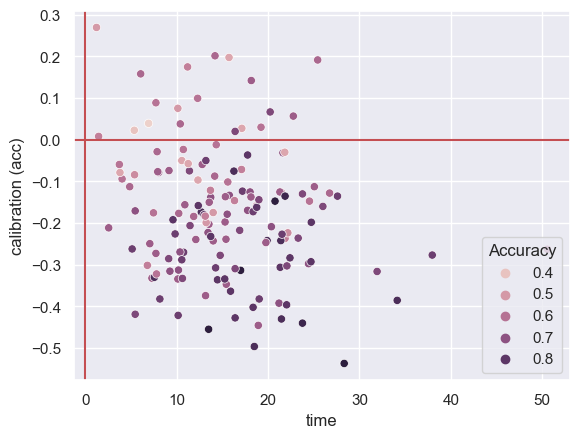

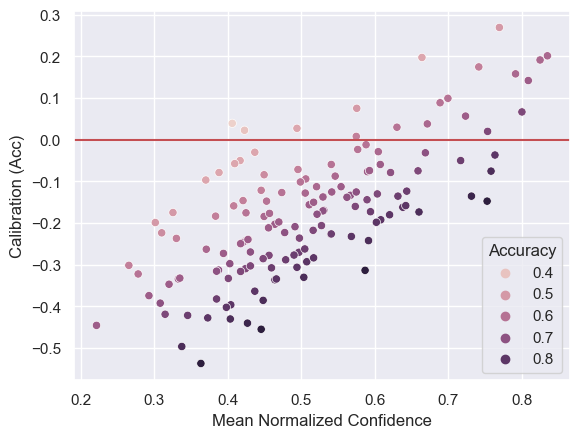

In [8]:
means = data.groupby('user_id')[['userconf', 'time', 'correct']].mean()
means = means.rename(columns={'correct':'accuracy'})
means['calibration (acc)'] = means['userconf'] - means['accuracy']
display(means.head(2))

# fig, axes = plt.subplots(1,2, figsize=(18,5))

graph = sns.scatterplot(means, x='time', y='calibration (acc)', hue='accuracy')
graph.set(title='Calibration (acc) by mean answering time' if titles else "")
graph.axhline(y=0, c='r')
graph.axvline(x=0, c='r')
graph.legend(loc='lower right', title="Accuracy")
plt.show()

graph = sns.scatterplot(means, x='userconf', y='calibration (acc)', hue='accuracy')
graph.set(title='Calibration (Acc) by Mean Normalized Confidence' if titles else "", xlabel="Mean Normalized Confidence", ylabel="Calibration (Acc)")
graph.axhline(y=0, c='r')
# graph.axvline(x=0, c='r')
graph.legend(loc='lower right', title="Accuracy")
plt.savefig(f"results/calibration/Calibration (Acc) by Mean Normalized Confidence")
plt.show()

### Calibration by answering time

In [9]:
# For each answering, calulcating its answering time delta from users avergae delta.
# For example, lets say that user A is usually 4 sec faster than the average answering time.
# Then, there's a question in which she was 6 sec faster. This question was probabley easier for her, and its time delta will be -2.
tdata = data.copy()
questions_mtime = tdata.groupby('order')['time'].mean()
tdata = tdata.join(questions_mtime, on='order',rsuffix=' mean')
tdata['time delta'] = tdata['time'] - tdata['time mean']
users_mdelta = tdata.groupby('user_id')['time delta'].mean()
tdata = tdata.join(users_mdelta, on='user_id',rsuffix=' mean')
tdata['delta from delta'] = tdata['time delta'] - tdata['time delta mean']
data.insert(8, 'time_delta', tdata['delta from delta'])

# For each user, divide the answers into 3 buckets, depending on the relative answering time
users_quantiles = data.groupby('user_id')['time_delta'].agg(q1=lambda x: np.quantile(x,1/3), q2=lambda x: np.quantile(x,2/3))
tdata = tdata.join(users_quantiles, on='user_id')
tdata.loc[tdata['delta from delta']<=tdata['q1'], 'quantile'] = 1
tdata.loc[(tdata['delta from delta'] > tdata['q1'])&(tdata['delta from delta'] <= tdata['q2']), 'quantile'] = 2
tdata.loc[tdata['delta from delta'] > tdata['q2'], 'quantile'] = 3
data.insert(9, 'quantile', tdata['quantile'])

# Divide the users into 3 buckets, depending on the average answering time
users_mdelta = pd.DataFrame(users_mdelta)
users_mdelta['delta bucket'] = users_mdelta['time delta'].quantile(1)
q = 0.5
users_mdelta.loc[users_mdelta['time delta'] < users_mdelta['time delta'].quantile(q), 'delta bucket'] = users_mdelta['time delta'].quantile(q)

tdata = tdata.join(users_mdelta[['delta bucket']], on='user_id')
data.insert(10, 'delta bucket', tdata['delta bucket'])

#### Calibration as meanconf - precision

delta bucket  precision  userconf  calibration (pre)
user_id quantile                                                      
174     1.0          -0.882313   0.333333  0.696667           0.363333
        2.0          -0.882313   0.714286  0.517143          -0.197143

,precision,size
delta bucket,,
-0.882313,0.627961,219
35.217687,0.688499,222


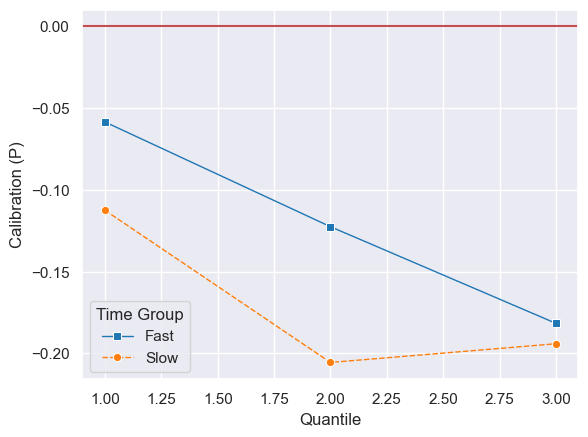

In [10]:
means = data.loc[data['confusion'].isin(['TP', 'FP']), ['user_id', 'delta bucket', 'quantile', 'correct', 'userconf']].groupby(['user_id', 'quantile']).agg({'delta bucket':'first'}|{f:'mean' for f in ['correct', 'userconf']})
means = means.rename(columns={'correct':'precision'})
means['calibration (pre)'] = means['userconf'] - means['precision']
display(means.head(2))
delta_buckets = means.groupby(['delta bucket'])[['precision']].agg(precision=('precision', 'mean'), size=('precision', 'size'))
display(delta_buckets)

graph = sns.lineplot(means, x='quantile', y='calibration (pre)',hue='delta bucket', style='delta bucket', markers=["s", "o"], errorbar=None, linewidth=1, palette='tab10')
graph.set(title='Calibration (P) by Answering Time Quantile, per Time Group' if titles else "", xlabel='Quantile', ylabel="Calibration (P)")
graph.axhline(y=0, c='r')
leg = graph.legend(title="Time Group", labels=['Fast', 'Slow'])
# for t in leg.texts:
#     t.set_text(round(float(t.get_text()),2))

plt.savefig(f"results/calibration/Calibration (P) by Answering Time Quantile, per Time Group")
plt.show()

#### Calibration as meanconf - accuracy

,accuracy,size
delta bucket,,
-0.882313,0.652899,219
35.217687,0.718018,222


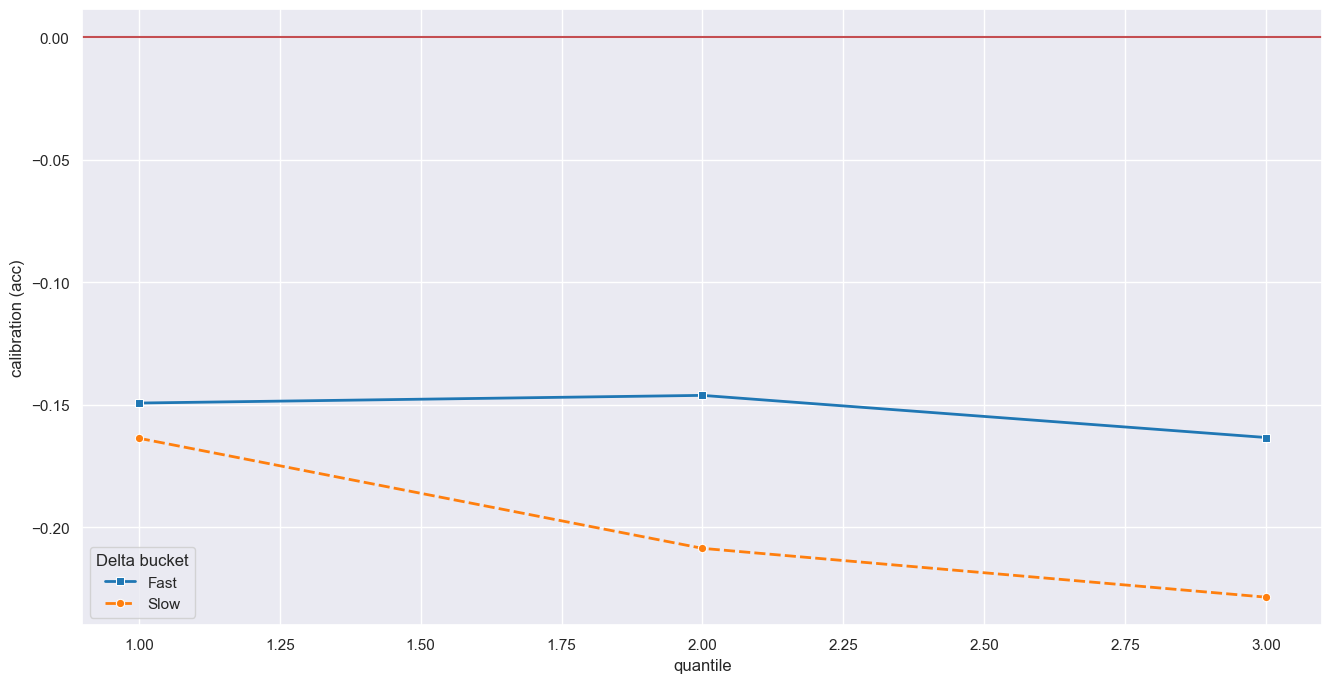

In [11]:
means = data.groupby(['user_id', 'quantile'])[['delta bucket', 'userconf', 'correct']].agg({'delta bucket':'first', 'userconf':'mean', 'correct':'mean'})
means = means.rename(columns={'correct':'accuracy'})
means['calibration (acc)'] = means['userconf'] - means['accuracy']
delta_buckets = means.groupby(['delta bucket'])[['accuracy']].agg(accuracy=('accuracy', 'mean'), size=('accuracy', 'size'))
display(delta_buckets)

fig, ax = plt.subplots(1,1,figsize=(16,8))
graph = sns.lineplot(means, x='quantile', y='calibration (acc)',hue='delta bucket', style='delta bucket', ax=ax, markers=["s", "o"], errorbar=None, linewidth=2, palette='tab10')

graph.set(title='Calibration (acc) by answering time quantile, for each delta bucket' if titles else "")
graph.axhline(y=0, c='r')
leg = graph.legend(title="Delta bucket", labels=['Fast', 'Slow'])
# for t in leg.texts:
#     t.set_text(round(float(t.get_text()),2))

plt.show()

### Calibration by realconf

,calibration (acc)
realconf,
0,-0.041406
1,-0.312136


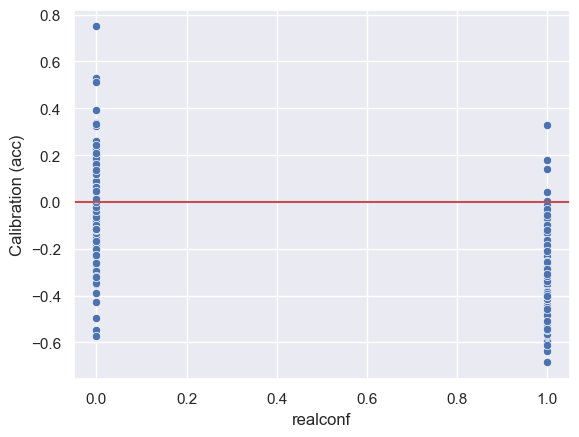

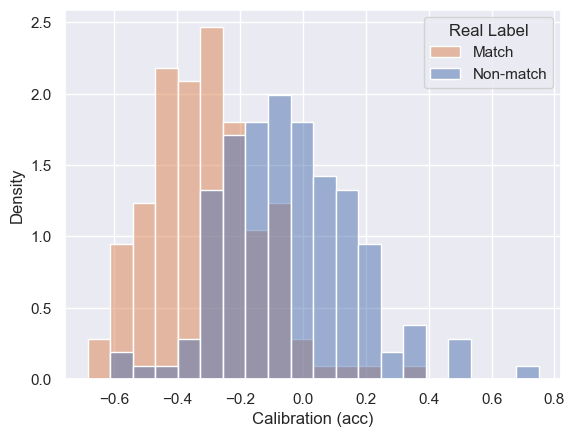

In [12]:
means = data.groupby(['user_id', 'realconf'])[['userconf', 'correct']].mean()
means = means.rename(columns={'correct':'accuracy'})
means['calibration (acc)'] = means['userconf'] - means['accuracy']

# fig, axes = plt.subplots(1,2, figsize=(16,4))

display(means.groupby('realconf')[['calibration (acc)']].mean())
graph = sns.scatterplot(means, x='realconf', y='calibration (acc)')
graph.set(title="Calibration by ground truth" if titles else "", ylabel='Calibration (acc)')
graph.axhline(y=0, c='r')
plt.show()

graph = sns.histplot(means, x='calibration (acc)', hue='realconf', bins=20, stat='density', common_norm=False)
graph.set(title="Calibration Distribution by Real Label" if titles else "", xlabel='Calibration (acc)')
graph.legend(title="Real Label", labels=['Match', 'Non-match'])
# extent = axes[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig(f"results/calibration/Calibration (Acc) Distribution by Real Label")
plt.show()

Confidence

,userconf
realconf,
0,0.513696
1,0.504190


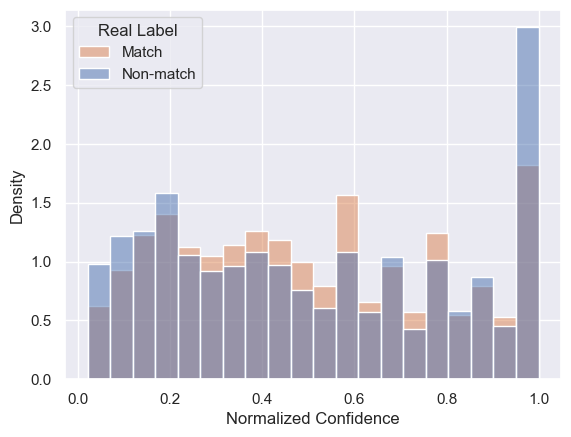

In [13]:
display(means.groupby('realconf')[['userconf']].mean())
graph = sns.histplot(data, x='userconf', hue='realconf', bins=20, stat='density', common_norm=False)
graph.set(title="Normalized Confidence Distribution by Real Label" if titles else "", xlabel='Normalized Confidence')
graph.legend(title="Real Label", labels=['Match', 'Non-match'])
plt.savefig("results/calibration/Normalized Confidence Distribution by Real Label")
plt.show()

,userconf
realconf,
0,0.513696
1,0.504190


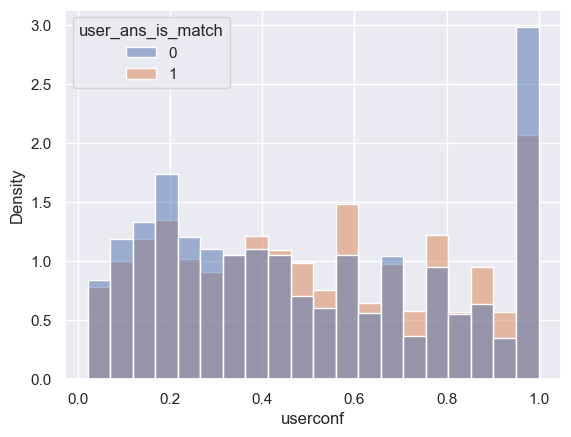

In [14]:
display(means.groupby('realconf')[['userconf']].mean())
sns.histplot(data, x='userconf', hue='user_ans_is_match', bins=20, stat='density', common_norm=False)
plt.show()

Accuracy

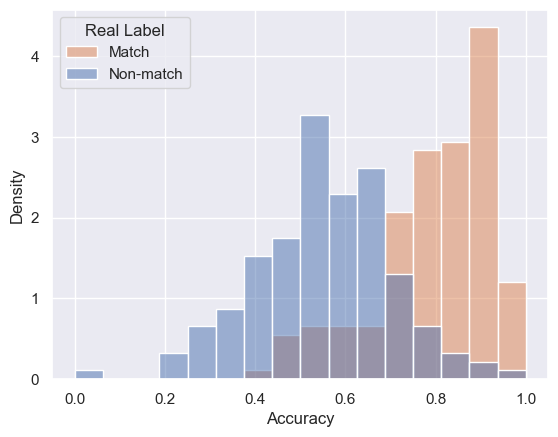

In [15]:
# display(means.groupby('realconf')[['accuracy']].mean())
# graph = sns.scatterplot(means, x='realconf', y='accuracy')
# graph.set(title="Accuracy by ground truth")
# graph.axhline(y=0, c='r')
# plt.show()

graph = sns.histplot(means, x='accuracy', hue='realconf', bins=16, stat='density', common_norm=False)
graph.set(title="Accuracy Distribution by Real Label" if titles else "", xlabel='Accuracy')
graph.legend(title="Real Label", labels=['Match', 'Non-match'])
plt.savefig("results/calibration/Accuracy Distribution by Real Label")
plt.show()

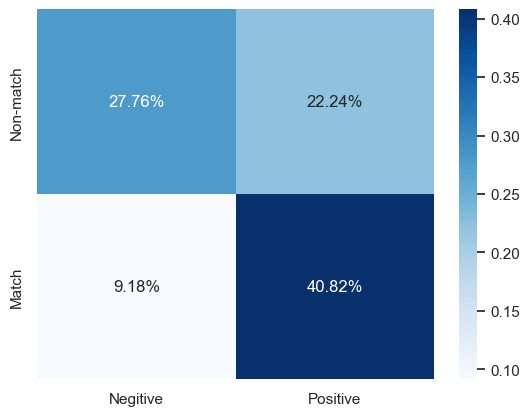

In [16]:
cf_matrix = confusion_matrix(data['realconf'], data['user_ans_is_match'])
cf_matrix = pd.DataFrame(cf_matrix, index=['Non-match', 'Match'], columns=['Negitive', 'Positive'])
heatmap = sns.heatmap(cf_matrix/cf_matrix.values.sum(), annot=True, fmt='.2%', cmap='Blues')
heatmap.set(title='Confusion matrix' if titles else "")
plt.savefig("results/calibration/Confusion matrix")
plt.show()

### Calibration by exp_id

,calibration (pre)
exp_id,
14,-0.120135
15,-0.176745


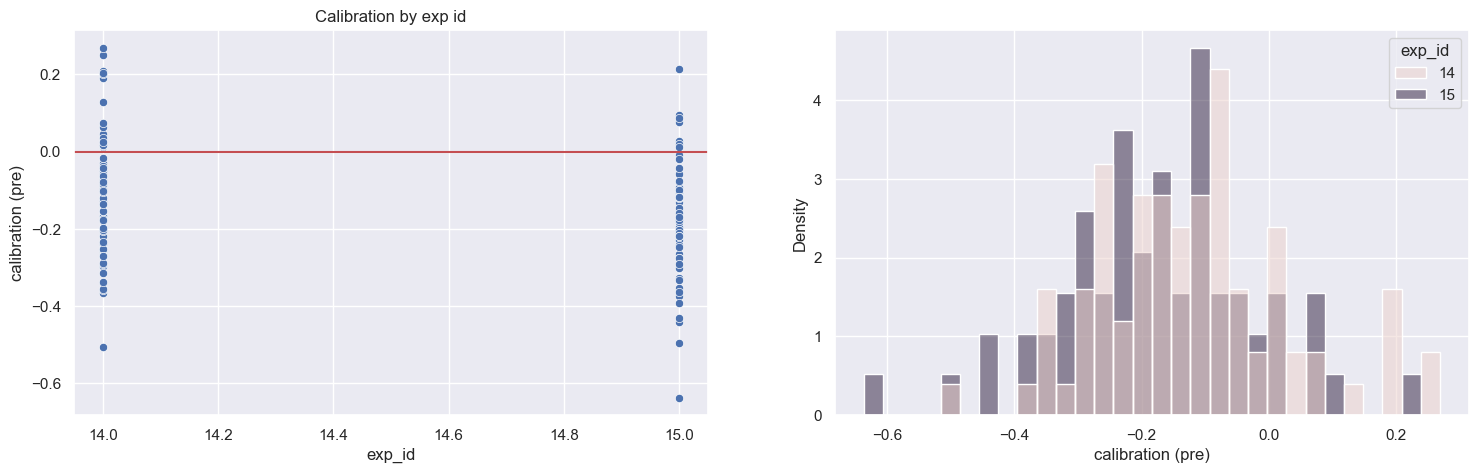

In [17]:
means = data.groupby(['user_id', 'exp_id'])[['userconf']].mean()
means['precision'] = data.loc[data['confusion'].isin(['TP', 'FP']), ['user_id', 'exp_id', 'correct']].groupby(['user_id', 'exp_id']).mean()['correct']
means['calibration (pre)'] = means['userconf'] - means['precision']

fig, axes = plt.subplots(1,2, figsize=(18,5))

display(means.groupby('exp_id')[['calibration (pre)']].mean())
graph = sns.scatterplot(means, x='exp_id', y='calibration (pre)', ax=axes[0])
graph.set(title="Calibration by exp id")
graph.axhline(y=0, c='r')

sns.histplot(means, x='calibration (pre)', hue='exp_id', bins=30, stat='density', ax=axes[1], common_norm=False)
plt.show()